In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [293]:
import networkx as nx
from collections import deque
from grave import plot_network
import matplotlib.pyplot as plt
import random

In [294]:
class dBG:
    '''A basic de Bruijn Graph.
    '''

    def __init__(self, ksize, Sigma='ACGT', *args, **kwargs):
        self.store = set()
        self.tags = set()
        self.ksize = ksize
        self.Sigma = Sigma
        self.Sigma_set = set(self.Sigma)
        self.Sigma_list = list(self.Sigma)
        
    def kmers(self, sequence):
        '''Yields the k-mers in the given sequence.
        '''
        for i in range(len(sequence) - self.ksize + 1):
            yield sequence[i:i+self.ksize]

    def reset(self):
        '''Reset the dBG to an empty state.
        '''
        self.store.clear()

    def get(self, item):
        '''Return true if the item is in the dBG, false otherwise
        '''
        return item in self.store

    def add(self, item):
        '''Add the k-mer(s) from the given sequence to the dBG.
        '''
        if len(item) < self.ksize:
            raise ValueError(item)
        elif len(item) == self.ksize:
            self.store.add(item)
        else:
            self.store.update(self.kmers(item))
    
    def tag(self, item, dist=3):
        if len(item) < self.ksize:
            raise ValueError(item)
        count = 0
        n_tagged = 0
        for kmer in self.kmers(item):
            if kmer in self.tags:
                count = 0
            else:
                count += 1
                if count > dist:
                    self.tags.add(kmer)
                    count = 0
                    n_tagged += 1
        return n_tagged
    
    def remove(self, item):
        '''Remove the k-mer(s) from the given sequence from the dBG.
        '''
        if len(item) < self.ksize:
            raise ValueError(item)
        elif len(item) == self.ksize:
            self.store.remove(item)
        else:
            self.store.difference_update(self.kmers(item))
    
    def suffix(self, sequence):
        '''Returns the length k-1 suffix of the sequence.
        '''
        if len(sequence) < self.ksize:
            raise ValueError('Sequence too short')
        return sequence[-self.ksize+1:]
    
    def prefix(self, sequence):
        '''Returns the length k-1 prefix of the sequence.
        '''
        if len(sequence) < self.ksize:
            raise ValueError('Sequence too short')
        return sequence[:self.ksize-1]
    
    def left_neighbors(self, item):
        '''Yields the four left neighbors of the given k-mer.
        '''
        prefix = self.prefix(item)
        for b in self.Sigma:
            yield b + prefix
    
    def right_neighbors(self, item):
        '''Yields the four right neighbors of the given k-mer.
        '''
        suffix = self.suffix(item)
        for b in self.Sigma:
            yield suffix + b

    def left_degree(self, item):
        '''Yields the in-degree (left degree) of the given k-mer.
        '''
        return sum((self.get(neighbor) for neighbor in self.left_neighbors(item)))

    def right_degree(self, item):
        '''Yields the out-degree (right degree) of the given k-mer.
        '''
        return sum((self.get(neighbor) for neighbor in self.right_neighbors(item)))
    
    def degree(self, item):
        return self.left_degree(item), self.right_degree(item)
    
    def is_decision(self, kmer):
        '''Returns True if the given k-mer is a decision k-mer in the dBG:
        that is, if its in-degree or out-degree is greater than one.
        '''
        return self.left_degree(kmer) > 1 or self.right_degree(kmer) > 1

    def find_decisions(self, sequence):
        '''Yields the position and k-mer sequence of the decision k-mers in the 
        given sequence.
        '''
        for n, kmer in enumerate(self.kmers(sequence)):
            if self.is_decision(kmer):
                yield n, kmer
    
    def compactify(self, debug=False):
        '''Return a networkx DiGraph of the compacted dBG; unitigs and decision nodes
        each have their own nodes and are connected by directed edges, with nodes labeled
        with a 'kind' attribute of either 'unitig' or 'decision'.
        '''
        def _print(*args, **kwargs):
            if debug:
                print(*args, **kwargs)
        
        def _add_seen(kmer, seen):
            _print('add', kmer, 'to seen')
            seen.add(kmer)
        
        def _traverse_bidirectional(root, seen, tags):
            _print('traverse from', root)
            if self.is_decision(root):
                return None, [], None
            
            path = deque()
            path.append(root)
            ldnode = None
            rdnode = None
            while True:
                neighbors = ([neighbor for neighbor in self.left_neighbors(root) if self.get(neighbor)],
                              [neighbor for neighbor in self.right_neighbors(root) if self.get(neighbor)])
                if len(neighbors[0]) > 1 or len(neighbors[1]) > 1:
                    _print('stoped at left dnode')
                    ldnode = root
                    path.popleft()
                    break
                elif len(neighbors[0]) == 0:
                    _print('stopped at dead end')
                    _add_seen(root, seen)
                    break
                else:
                    _print('continue left')
                    path.appendleft(neighbors[0][0])
                    _add_seen(root, seen)
                    root = neighbors[0][0]
                    try:
                        tags.remove(root)
                    except KeyError:
                        pass
    
            root = path[-1]
            while True:
                neighbors = ([neighbor for neighbor in self.left_neighbors(root) if self.get(neighbor)],
                              [neighbor for neighbor in self.right_neighbors(root) if self.get(neighbor)])
                _print(neighbors)
                if len(neighbors[0]) > 1 or len(neighbors[1]) > 1:
                    _print('stopped at right dnode')
                    rdnode = root
                    path.pop()
                    break
                elif len(neighbors[1]) == 0:
                    _print('stopped at dead end')
                    _add_seen(root, seen)
                    break
                else:
                    _print('continue right')
                    path.append(neighbors[1][0])
                    _add_seen(root, seen)
                    root = neighbors[1][0]
                    try:
                        tags.remove(root)
                    except KeyError:
                        pass
            _print(ldnode, path, rdnode)
            return ldnode, path, rdnode
                    
        def _compactify(root, cdbg, seen, tags):
            _print('_compactify from', root)
            if root in seen:
                _print(root, 'in seen')
                return
            
            try:
                tags.remove(root)
                _print('Removed tag', root)
            except KeyError:
                pass
            
            if self.is_decision(root):
                _print('Found decision node', root)
                cdbg.add_node(root, path=[root], kind='decision')
                _add_seen(root, seen)
                for neighbor in self.left_neighbors(root):
                    if self.get(neighbor) and neighbor not in seen:
                        if self.is_decision(neighbor):
                            cdbg.add_node(neighbor, path=[neighbor], kind='decision')
                            cdbg.add_edge(neighbor, root)
                        _compactify(neighbor, cdbg, seen, tags)
                for neighbor in self.right_neighbors(root):
                    if self.get(neighbor) and neighbor not in seen:
                        _print('right neighbor', neighbor)
                        if self.is_decision(neighbor):
                            cdbg.add_node(neighbor, path='neighbor', kind='decision')
                            cdbg.add_edge(root, neighbor)
                        _compactify(neighbor, cdbg, seen, tags)
            else:
                l, path, r = _traverse_bidirectional(root, seen, tags)
                unode = (path[0], path[-1])
                cdbg.add_node(unode, path=path, kind='unitig')
                if l is not None:
                    cdbg.add_edge(l, unode)
                    _compactify(l, cdbg, seen, tags)
                if r is not None:
                    cdbg.add_edge(unode, r)
                    _compactify(r, cdbg, seen, tags)

        G = nx.DiGraph()
        global_seen = set()
        tags = set(self.tags)
        while tags:
            root = tags.pop()
            _compactify(root, G, global_seen, tags)
        
        return G
    
    def plot_cdbg(self, sequence_label=None, debug=False):
        G = self.compactify(debug=debug)

        def font_styler(attributes):
            return {'font_size': 8,
                    'font_weight': .5}

        def color_nodes(node_attrs):
            style = {'size': 100}
            if node_attrs.get('kind') == 'decision':
                style['color'] = 'red'
            else:
                style ['color'] = 'black'  

            if sequence_label is not None:
                if all((kmer in sequence_label for kmer in node_attrs.get('path', []))):
                    style['edgecolor'] = 'blue'
                    style['width'] = 2.0

            return style

        fig, ax = plt.subplots(figsize=(8,8))
        plot_network(G, ax=ax,
                     node_style=color_nodes,
                     #node_label_style=font_styler,
                     layout='kamada_kawai')
        return G

In [277]:
class SequenceGenerator:
    
    def __init__(self, ksize=13, graph=None, max_tries=100, rseed=None, *args, **kwargs):
        self.max_tries = max_tries
        if graph is None:
            self.graph = dBG(ksize)
        else:
            if not isinstance(graph, dBG):
                raise TypeError('graph must be a {0}'.format(dBG.__name__))
            self.graph = graph

        random.seed(rseed)
    
    def __getattr__(self, attr):
        return getattr(self.graph, attr)
    
    def generate(self, length, *args, **kwargs):
        return self.random_lmer(length)
    
    def validate(self, *args, **kwargs):
        raise NotImplementedError()
    
    def random_lexicographic_ordering(self):
        
        def _incr(base):
            return self.Sigma[self.Sigma.find(base) + 1]
        
        def _next(kmer):
            
            i = self.ksize - 1
            while kmer[i] == self.Sigma[-1] and i >= 0:
                i -= 1
            if i == -1:
                return self.Sigma[0] * self.ksize
            else:
                kmer = list(kmer)
                kmer[i] = _incr(kmer[i])
                
                return ''.join(kmer[:i+1]) + self.Sigma[0] * (self.ksize - i - 1)
        
        def ordering():
            start = self.random_kmer()
            yield start
            kmer = _next(start)
            while kmer != start:
                yield kmer
                kmer = _next(kmer)
        
        return ordering

    def random_base(self):
        '''Return a random base from the alphabet Sigma
        '''
        return random.choice(self.Sigma)
    
    def mutate_base(self, base, exclude=None):
        '''Mutate base, excluding the given options as possible targets.
        '''
        if exclude is None:
            exclude = set()
    
        exclude.add(base)
        if len(exclude) == len(self.graph.Sigma):
            raise ValueError('Tried to exclude all bases.')
        return random.choice(tuple(self.Sigma_set - exclude))
    
    def mutate_position(self, sequence, position, exclude=None):
        '''Return a copy of sequence mutated at the given position.
        '''
        base = self.mutate_base(sequence[position], exclude=exclude)
        sequence = list(sequence)
        sequence[position] = base
        return ''.join(sequence)
        
    def randomize_sigma(self):
        '''Returns the underlying alphabet Sigma in randomized order.
        '''
        return random.sample(self.Sigma, len(self.Sigma))
    
    def random_lmer(self, l):
        '''Generate a random sequence of length l
        '''
        return ''.join((self.random_base() for _ in range(l)))
    
    def random_kmer(self):
        '''Generates a random k-mer of length ksize.
        '''
        return self.random_lmer(self.ksize)
    
    def random_seed(self):
        '''Generates a random k-mer with no neighbors.
        '''
        seed = self.random_kmer()
        while self.graph.left_degree(seed) or self.graph.right_degree(seed):
            seed = self.random_kmer()
        self.tags.add(seed)
        return seed
    
    def random_unitig_base(self, seed, fw=True):
        '''Greedily unitig extend a single base in the given direction.
        '''
        if fw:
            neighbors = self.right_neighbors
        else:
            neighbors = self.left_neighbors
        
        extensions = self.randomize_sigma()
        result = None
        for base in extensions:
            if fw:
                kmer = self.suffix(seed) + base
            else:
                kmer = base + self.prefix(seed)
                
            if self.get(kmer):
                continue

            pre_add_decision = list((self.is_decision(neighbor) for neighbor in neighbors(kmer)))
            self.add(kmer)
            post_add_decision = list((self.is_decision(neighbor) for neighbor in neighbors(kmer)))
            if self.is_decision(kmer) or pre_add_decision != post_add_decision:
                self.remove(kmer)
            else:
                result = base
                break
        
        return result
    
    def random_new_base(self, seed, fw=True):
        extensions = self.randomize_sigma()
        result = None
        for base in extensions:
            if fw:
                kmer = self.suffix(seed) + base
            else:
                kmer = base + self.prefix(seed)
            if self.get(kmer):
                continue
            else:
                self.add(kmer)
                result = base
                break

        return result
    
    def random_degree_base(self, seed, degree, fw=True):
        extensions = self.randomize_sigma()
        result = None
        for base in extensions:
            if fw:
                kmer = self.suffix(seed) + base
            else:
                kmer = base + self.prefix(seed)
            if self.get(kmer):
                continue
            self.add(kmer)
            if self.degree(kmer) != degree:
                self.remove(kmer)
            else:
                result = base
                break
    
        return result
    
    def random_unitig_extend(self, seed, fw=True, N=1):
        '''Greedily extend the given seed by N bases such that any added sequence is a unitig. That is,
        added k-mers will not be decision k-mers, nor will they decision-induce any k-mers in the dBG.
        
        May get stuck in a dead-end and raise ValueError.
        '''
        
        # bind some stuff to function scope
        ksize = self.ksize
        random_lmer = self.random_lmer
        graph = self.graph
        get = self.get
        add = self.add
        remove = self.remove
        is_decision = self.is_decision
        
        # First step is to extend the seed out to length K if it isn't already
        _seed = seed

        if len(seed) < ksize:
            seed = _seed + random_lmer(ksize - len(_seed))
            add(seed)
            n_tries = 0
            while is_decision(seed):
                remove(seed)
                seed = _seed + random_lmer(ksize - len(_seed))
                add(seed)
                n_tries += 1
                if n_tries > self.max_tries:
                    raise ValueError('Exceeded max_tries when generating'
                                     'non-decision seed ({0} tries)'.format(n_tries))
       
        while N > 0:
            
            extension = self.random_unitig_base(seed, fw=fw)
            if extension is None:
                raise ValueError('Greedy dead-end, try again')
            else:
                if fw:
                    seed += extension
                else:
                    seed = extension + seed
            
            N = N - 1
            
        return seed
    
    def random_unitig(self, L):
        '''Generate a random unitig of length L >= K.
        '''
        if L < self.ksize:
            raise ValueError('length is < K')
        seed = self.random_seed()
        return self.random_unitig_extend(seed, N=L-self.ksize)
    
    def random_branches(self, seed, n_branches, n_tail_kmers=1, fw=True):
        if n_branches > len(self.Sigma) or n_branches < 1:
            raise ValueError('Invalid number of branches.')
        
        yield from (self.random_unitig_extend(seed, fw=fw, N=n_tail_kmers) for _ in range(n_branches))
    
    def get_decision_neighborhood(self, sequence):
        kmers = list(self.kmers(sequence))
        neighborhood = []
        neighborhood.append(list((self.is_decision(neighbor) for neighbor in self.left_neighbors(kmers[0]))))
        if len(kmers) > 2:
            for kmer in kmers[1:-1]:
                neighborhood.append(list((self.is_decision(neighbor) for neighbor in self.left_neighbors(kmer))))
                neighborhood.append(list((self.is_decision(neighbor) for neighbor in self.right_neighbors(kmer))))
        neighborhood.append(list((self.is_decision(neighbor) for neighbor in self.right_neighbors(kmers[-1]))))
        
        return neighborhood
                
    def has_decision_inducers(self, segment):
        before = self.get_decision_neighborhood(segment)
        self.add(segment)
        after = self.get_decision_neighborhood(segment)
        self.remove(segment)
        
        return before != after

    def random_unitig_merge(self, left, right, n_kmers=3):
        '''Given unitigs left and right, merge them together by adding
        n_kmers bases between them such that the merged sequence is still a
        unitig. If this is not possible, raises ValueError.'''
        
        _left = self.suffix(left)
        _right = self.prefix(right)
        
        seeder = self.random_lexicographic_ordering()
        n_tries = 0
        for seed in seeder():
            n_tries += 1
            segment = _left + seed + _right
            if not self.has_decision_inducers(segment):
                self.add(segment)
                return left + seed + right
            
        raise ValueError('Unable to merge without inducing new decision k-mers, tried', n_tries)

In [ ]:
          CGTTTAA
         CCGTTTA
      ATGCCGT
       TGCCGTT
TTAGTTGTGCCGTTTATACAGGTCCAA
        GCCGTTA
       CGCCGTT

In [67]:
class BubbleGenerator(SequenceGenerator):
    
    def generate(self, n_branches=2, n_tail_kmers=0, visualize=False):
        if n_branches > len(self.Sigma) or n_branches < 2:
            raise ValueError('Invalid number of branches.')
        
        # Generate a seed k-mer and make n_branches copies
        start = self.random_unitig(self.ksize + n_tail_kmers)
        sequences = [start] * n_branches
        
        # extend each sequence with a mutant
        for i in range(n_branches):
            sequences[i] = self.random_unitig_extend(sequences[i], N=1)
        
        # extend a new k-mer off the end and append it to each sequence
        end = self.random_unitig_extend(sequences[0], self.ksize + n_tail_kmers)[len(sequences[0]):]
        for i in range(len(sequences)):
            self.add(self.suffix(sequences[i]) + end)
            sequences[i] += end
        
        if visualize:
            self.visualize(sequences, n_branches, n_tail_kmers)
        
        return sequences

    def visualize(self, sequences, n_branches, n_tail_kmers):
        out = '\n' + (' ' * n_tail_kmers) + '|' + (' ' * (self.ksize - 2)) + '|*' +\
              '|' + (' ' * (self.ksize - 2)) + '|\n'
        print(out.join(sequences))


In [68]:
class ForkGenerator(SequenceGenerator):
    
    def generate(self, n_branches=2, n_tail_kmers=None, visualize=False):
        if n_tail_kmers is None:
            n_tail_kmers = 1
        if n_tail_kmers < 1:
            raise ValueError('n_tail_kmers must be at least 1.')
        
        start = self.random_unitig(self.ksize + n_tail_kmers)
        sequences = [start] * n_branches

        # extend each sequence with a mutant
        for i in range(n_branches):
            sequences[i] = self.random_unitig_extend(sequences[i], N=n_tail_kmers)
        
        if visualize:
            self.visualize(sequences, n_branches, n_tail_kmers)
        
        return sequences
    
    def visualize(self, sequences, n_branches, n_tail_kmers):
        out = '\n' + (' ' * n_tail_kmers) + '|' + (' ' * (self.ksize - 2)) + '|*\n'
        print(out.join(sequences))


In [69]:
class TandemForkGenerator(SequenceGenerator):
    
    def generate(self, n_forks=2, n_branches=2, n_tail_kmers=None, visualize=False):
        if n_tail_kmers is None:
            n_tail_kmers = 1
        if n_tail_kmers < 1:
            raise ValueError('n_tail_kmers must be at least 1.')
        
        if n_forks < 2:
            raise ValueError('Invalid n_forks, must be >= 2 (otherwise they would not be tandem)')
        
        forks = []
        core = self.random_unitig(self.ksize + n_forks + (n_tail_kmers * 2))
        for start_kmer in range(n_tail_kmers, n_tail_kmers + n_forks):
            seed = core[:start_kmer+self.ksize]
            for branch in self.random_branches(seed, n_branches, n_tail_kmers=n_tail_kmers):
                forks.append(branch)
        core = self.random_unitig_extend(core, n_tail_kmers)
        
        return [core] + forks
        

In [286]:
class DecisionChainInducerGenerator(SequenceGenerator):
    
    def generate(self, n_decisions=2, n_tail_kmers=8):
        if n_tail_kmers < 1:
            raise ValueError('n_tail_kmers must be at least 1.')
        if n_decisions < 2:
            raise ValueError('Invalid n_decisions, must be >= 2 (otherwise they would not be a chain)')      
        
        sequences = []
        core = self.random_unitig(self.ksize + n_decisions + (n_tail_kmers * 2))
        inducer_seeds = []
        print(core)
        # create seeds for the inducer with right-branches
        fw = False
        for i, start_kmer in enumerate(range(n_tail_kmers, n_tail_kmers + n_decisions)):
            fw = not fw if i % 2 == 0 else fw
            root = core[start_kmer:start_kmer+self.ksize]
            seed = next(self.random_branches(root, 1, fw=fw, n_tail_kmers=n_tail_kmers))[1:]
            inducer_seeds.append(seed)
            print(' ' * (start_kmer-1), root)
            print(' ' * (start_kmer), seed)
        print('*' * 20)
        #for i in range(len(inducer_seeds)):
        #    fw = (i % 2 != 0)
        #    extension = self.random_degree_base(inducer_seeds[i], (0, 2), fw=fw)
        #    if extension is None:
        #        raise ValueError('Could not produce k-mer of request degree')
        #    inducer_seeds[i] = extension + inducer_seeds[i]
        
        inducer = self.random_seed()
        for seed in inducer_seeds:
            inducer = self.random_unitig_merge(inducer, seed, n_kmers=n_tail_kmers)
        
        return [core, inducer]

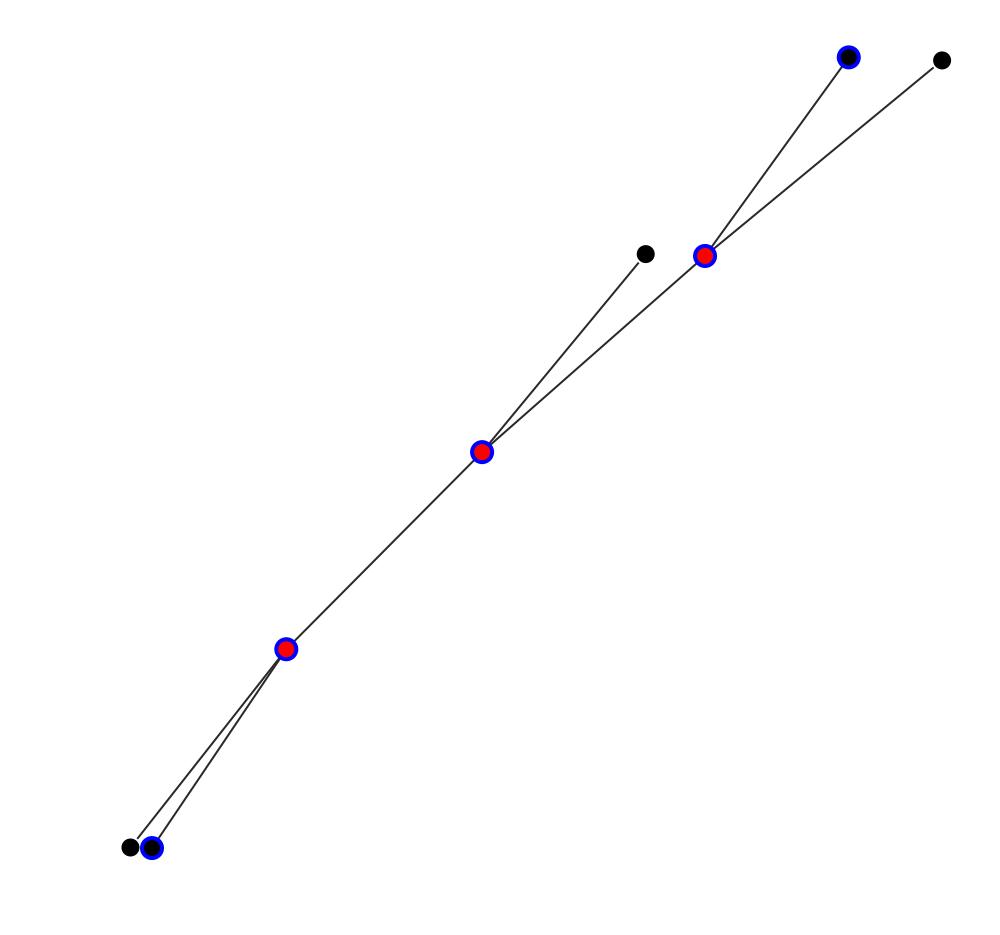

In [242]:
S = SequenceGenerator(ksize=7, rseed=0)
S.add('TTAGTTGTGCCGTTTATACAGGTCCAA')
S.add('ATGCCGT')
S.add('CGCCGTT')
S.add('CGTTTAA')
S.tags.add('ATGCCGT')
S.plot_cdbg(sequence_label='TTAGTTGTGCCGTTTATACAGGTCCAA')

AACGCCTACTAGACGGGTTGACCCA
        CTAGACG
         TAGACGATAAGCCT
         TAGACGG
          AGACGGCGTATATA
********************
TAAACGT
TAAACTA
TAAACTC
TAAACTG
AAAACTC
AAAACTG
AAAACTT
AAAAGAA
      AACGCCTACTAGACGGGTTGACCCA
TAAGACTTAAACTGTAGACGATAAGCCTAAAAGAAAGACGGCGTATATA


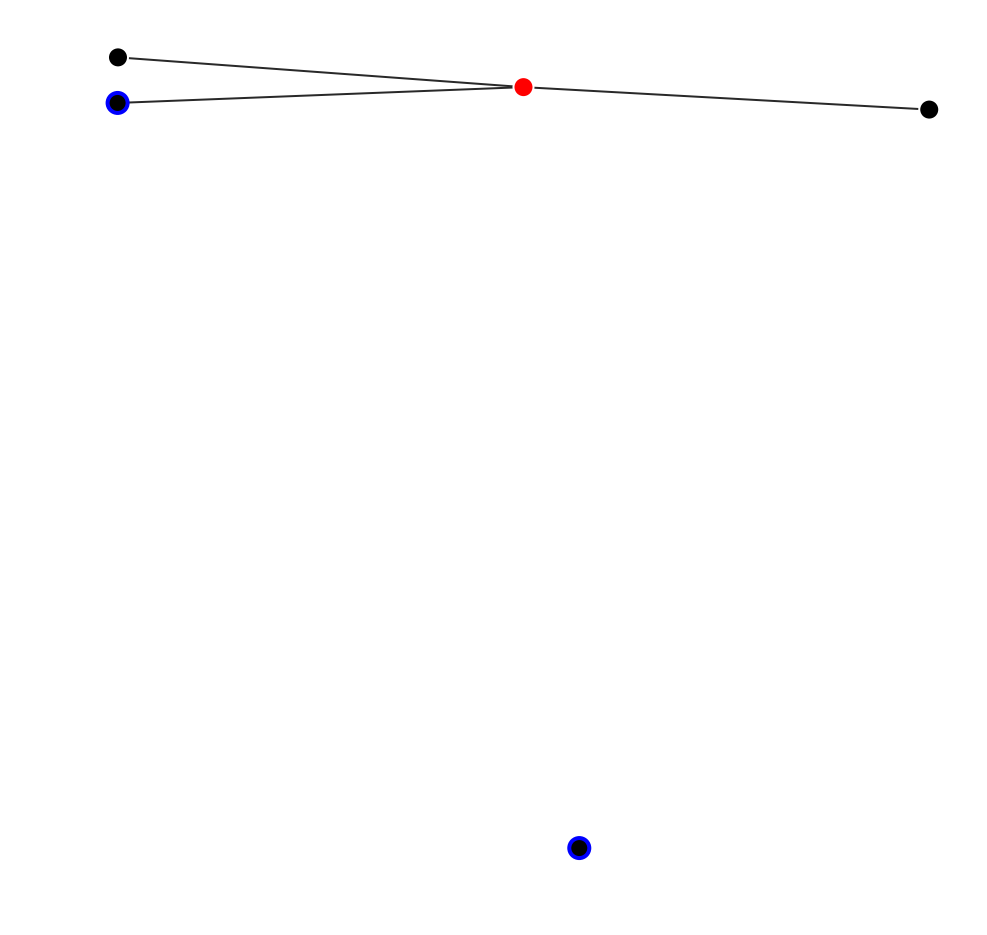

In [287]:
D = DecisionChainInducerGenerator(ksize=7)
sequences = D.generate(n_decisions=2)
G = D.plot_cdbg(sequence_label=sequences[0])
print(' ' * (D.ksize-1) + sequences[0], sequences[1], sep='\n')

In [101]:
D.store

{'AAGTTGT',
 'AGTTGTG',
 'AGTTGTT',
 'GTTGTGC',
 'GTTGTGT',
 'TAGTTGT',
 'TGTTGTG',
 'TTGTGCG'}

In [56]:
G.nodes

NodeView((('TTAGTTG', 'TTAGTTG'), 'TAGTTGT', 'AGTTGTG', ('GTTGTGC', 'TTGTGCG'), ('GTTGTGT', 'GTTGTGT'), 'TTGTGTT', ('ATTGTGT', 'ATTGTGT'), ('AGTTGTT', 'AGTTGTT'), 'GTTGTTA', ('GGTTGTT', 'GGTTGTT')))

In [24]:
T = TandemForkGenerator(7, rseed=0)

In [10]:
print('\n'.join(T.generate(n_forks=3)))

TTAGTTGTGCGTG
TTAGTTGTT
TTAGTTGTA
TTAGTTGTGT
TTAGTTGTGA
TTAGTTGTGCC
TTAGTTGTGCA


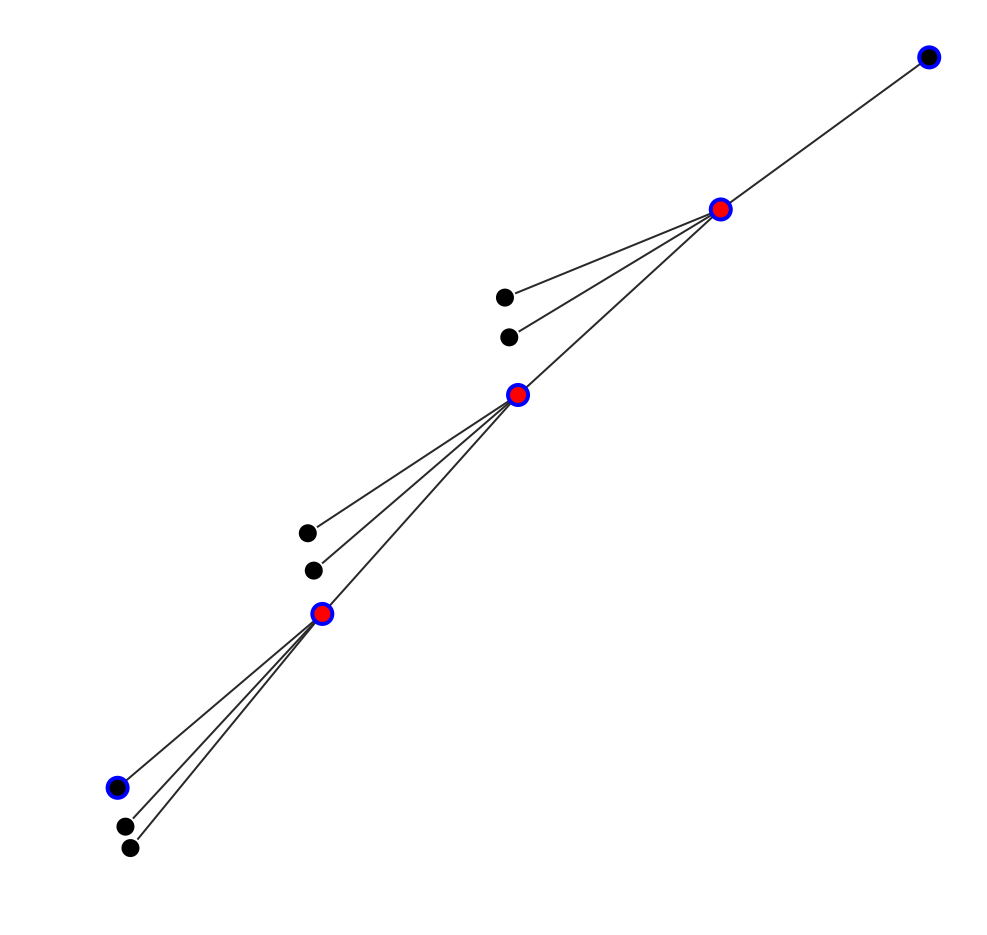

In [11]:
G = plot_cdbg(T, sequence_label='TTAGTTGTGCGTG')

In [12]:
B = BubbleGenerator(7, rseed=0)

In [13]:
sequences = B.generate(4, n_tail_kmers=2, visualize=True)

TTAGTTGTGCA
  |     |*|     |
TTAGTTGTGGA
  |     |*|     |
TTAGTTGTGTA
  |     |*|     |
TTAGTTGTGAA


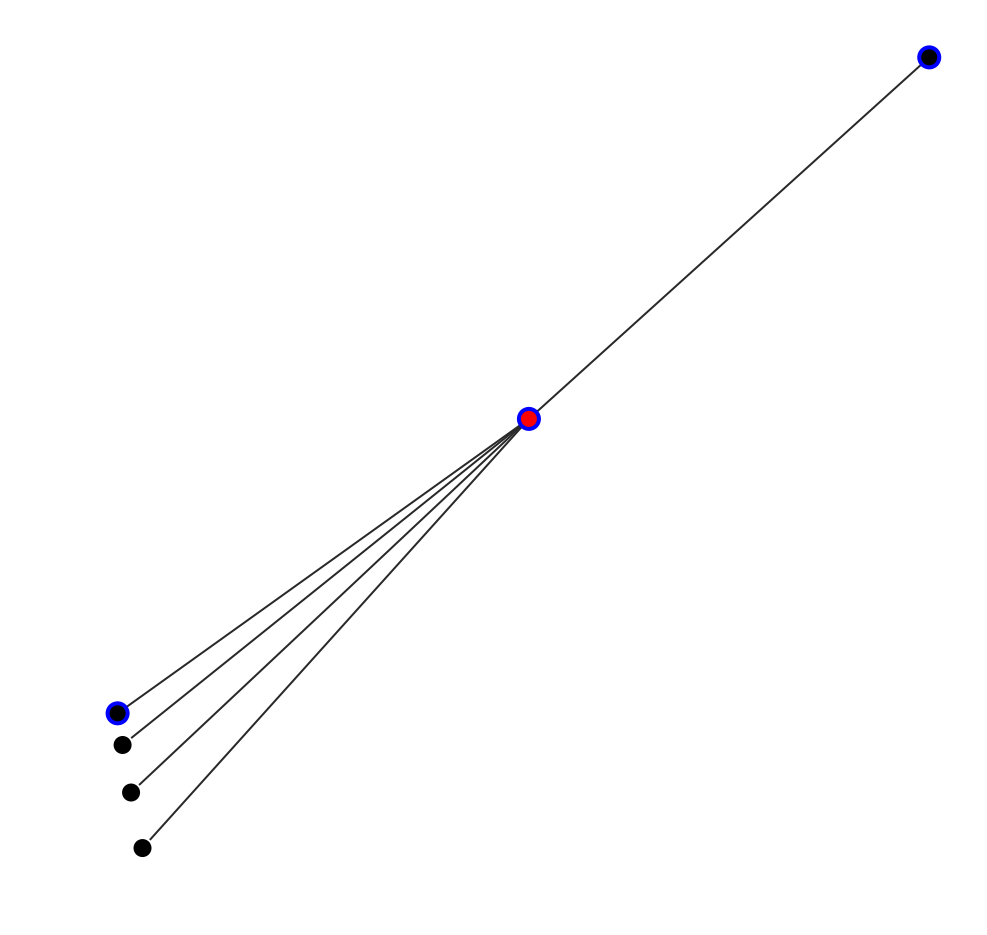

In [14]:
G = plot_cdbg(B, sequence_label=sequences[0])

In [15]:
F = ForkGenerator(7)

In [16]:
F.generate(4, n_tail_kmers=2, visualize=True)

CCGATGCCCGC
  |     |*
CCGATGCCCTT
  |     |*
CCGATGCCCAT
  |     |*
CCGATGCCCCC


['CCGATGCCCGC', 'CCGATGCCCTT', 'CCGATGCCCAT', 'CCGATGCCCCC']

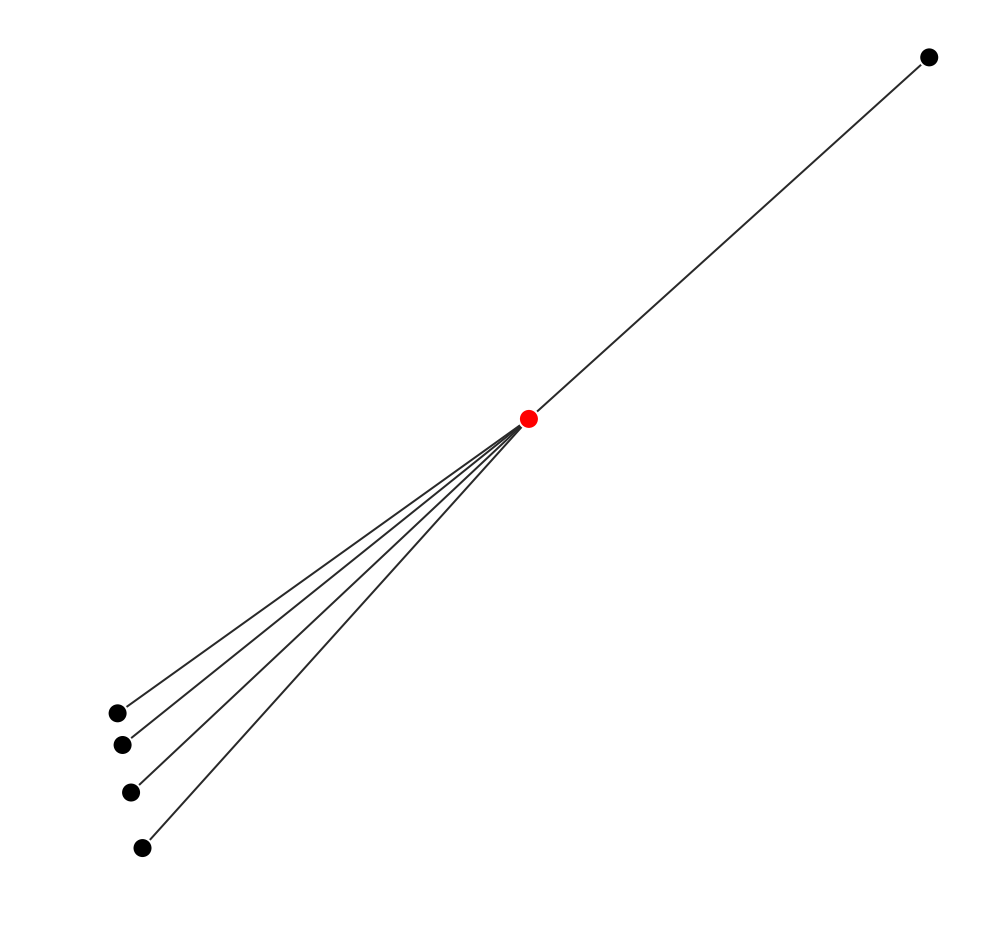

In [17]:
plot_cdbg(F)

In [295]:
G = dBG(ksize=27)

In [296]:
s = 'ACACCAATTACTAGTTCTAGTGTTCTTAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTTAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACAGCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTACACCAATTACTAGTTCTAGTGTTCTTAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTTAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACAGCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTCTGAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCTACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGTTCTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCTAGTATTCTTAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCATACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCACATCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGTTCTGAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGTTCTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTTAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAATACATCTACACCAATTACTAGTTCAAGTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCCCCCCAATTACTAGTTCAACTGTTGTAAATAGTTCTACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAACAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTGTGAATACATCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAACACATCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAATAGTTCCACACCAATTACTAGTTCAACTGTTCTGAACAGTTCCACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGCTCCACACCAATTACTAGTTCTAGTGTTCTTAACAGTTCCACACCAATTACTAGTTCAACTGTTGTGAATAGTTCTACACCAATTACTAGTTCTAGCGTTCTGAACAGTTCTACACCAATTACTAGTTCAACTGCTTTGAACACATCCACACCAATTACTAGTTCTAGTGTTCTGAACAGTTCCACACCAATTACTAGTTCTAGTGTTCTTAACACATC'

In [297]:
G.add(s)
G.tag(s)

160

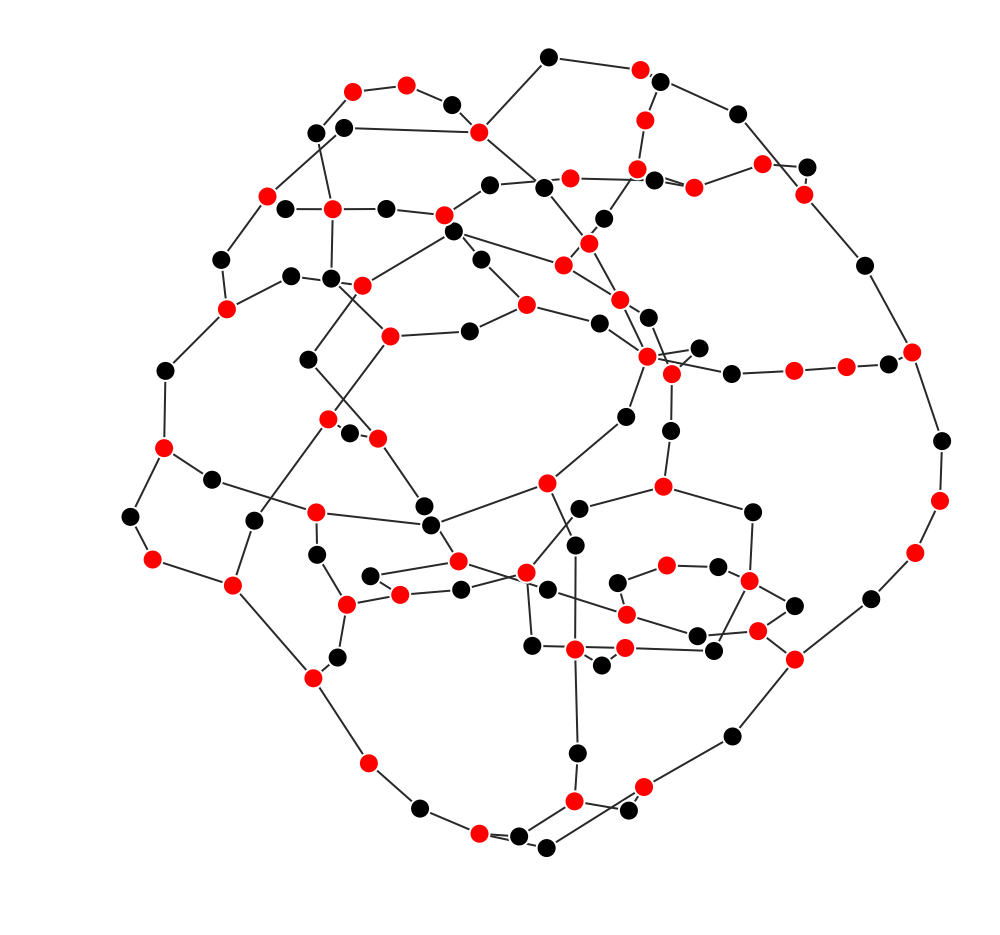

In [302]:
cdbg = G.plot_cdbg()

In [309]:
for node, attr in cdbg.nodes.data():
    if attr['kind'] == 'decision':
        print(attr['path'][0])

AGTTCTAGTGTTCTGAACAGTTCCACA
TACTAGTTCTAGTGTTCTGAACAGTTC
AATTACTAGTTCTAGTGTTCTGAACAG
ACCAATTACTAGTTCTAGTGTTCTGAA
ACACCAATTACTAGTTCTAGTGTTCTG
CACACCAATTACTAGTTCTAGTGTTCT
TCCACACCAATTACTAGTTCTAGTGTT
AACACATCCACACCAATTACTAGTTCT
GAACACATCCACACCAATTACTAGTTC
TGAACACATCCACACCAATTACTAGTT
CAATTACTAGTTCAACTGTTCTGAACA
ACACCAATTACTAGTTCAACTGTTCTG
TCCACACCAATTACTAGTTCAACTGTT
CATCCACACCAATTACTAGTTCAACTG
ACATCCACACCAATTACTAGTTCAACT
AACACATCCACACCAATTACTAGTTCA
TAACACATCCACACCAATTACTAGTTC
CAATTACTAGTTCTAGTGTTCTTAACA
ACACCAATTACTAGTTCTAGTGTTCTT
TACACCAATTACTAGTTCTAGTGTTCT
TTCTTAACAGTTCCACACCAATTACTA
AGTTCCACACCAATTACTAGTTCTAGT
AACAGTTCCACACCAATTACTAGTTCT
GAACAGTTCCACACCAATTACTAGTTC
TGTTCTGAACAGTTCCACACCAATTAC
AACAGTTCCACACCAATTACTAGTTCA
TAACAGTTCCACACCAATTACTAGTTC
AGTTCCACACCAATTACTAGTTCAACT
CAATTACTAGTTCTAGTGTTCTGAATA
AGTTCAACTGCTTTGAACACATCCACA
CTAGTTCAACTGCTTTGAACACATCCA
ACTAGTTCAACTGCTTTGAACACATCC
CAATTACTAGTTCAACTGCTTTGAACA
ACACCAATTACTAGTTCAACTGCTTTG
TCCACACCAATTACTAGTTCAACTGCT
GTTCCACACCAATTACTAGT

In [301]:
'TGAATAGTTCTACACCAATTACTAGTT' in s

True

In [299]:
for kmer in G.kmers(s):
    print(G.degree(kmer))

(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(2, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(3, 1)
(1, 1)
(1, 2)
(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(3, 1)
(1, 1)
(1, 2)
(2, 1)
(1, 1)
(2, 2)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 2)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(3, 2)
(1, 2)
(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(3, 1)
(1, 1)